# <center><b>Метод преноса стила описан у раду <br/> <i>A Neural Algorithm of Artistic Style (Gatys et al., 2015)</i></b></center>


Пренос стила у области рачунарског вида представља технику синтезе слике, где се на основу две улазне слике $\mathcal{C}$ и $\mathcal{S}$, садржај слике $\mathcal{C}$  представља у стилу слике $\mathcal{S}$. Популаризацију ове области рачунарског вида подстакао је управо рад *A Neural Algorithm of Artistic Style* аутора Gatys et al. (2015) применивши тада врло актуелне моделе засноване на дубоким неуронским мрежама (конволутивним неуронским мрежама) на овај проблем. Овај метод преноса стила користи VGG19 неуронску мрежу за препознавање садржаја слика (Simonyan & Zisserman, 2015) тренирану на [*ImageNet*](https://www.image-net.org/) скупу података. С обзиром на величину овог скупа података и време потребно за тренирање ове мреже, у овом раду биће коришћена два предтренирана модела VGG19 мреже, један из библиотеке `torchvision`, и један од аутора рада.

Основна идеја ове методе је да се некако раздвоје репрезентације садржаја и стила улазне слике. Како конволутивне неуронске мреже са растом дубине имају све комплексније атрибуте, то омогућава да се из неког дубљег слоја мреже узме репрезентација улазне слике која ће бити слична улазној слици у смислу објеката и њиховог распореда, али неће имати егзактне вредности пиксела улазне слике, што представља репрезентацију садржаја улазне слике. За репрезентацију стила улазне слике, користе се Грамове матрице репрезентација из различитих нивоа конволутивне неуронске мреже. Грамове матрице се користе да се информације о стилу одвоје од информација о просторној расподели улазне слике. Комбиновањем репрезентације садржаја једне и репрезентације стила друге слике, остварује се пренос стила. То се постиже оптимизовањем неке улазне слике, на пример, слике шума (енг. *noise image*), тако да се истовремено минимизује раздаљина од репрезентације садржаја прве слике, и раздаљина од репрезентације стила друге слике.

**Грамова матрица**

Ако је $x = (x_1, \ldots, x_n)$ скуп вектора неког еуклидског простора онда је Грамова матрица скупа $x$ квадратна матрица $G(x) = (\langle x_i, x_j \rangle)_{ij}, \forall i,j = 1 \ldots n$, односно:

$$
G(x) =   \begin{bmatrix} 
            \langle x_1, x_1 \rangle & \dots & \langle x_1, x_n \rangle \\
            \vdots & \ddots & \vdots \\
            \langle x_n, x_1 \rangle & \dots & \langle x_n, x_n \rangle 
          \end{bmatrix}
$$

Ако се скуп вектора $x$ запише као матрица $A = \big[\; x_1 \; \dots \; x_n \; \big]$, онда се Грамова матрица скупа $x$ може израчунати као $G(x) = A^TA$.



Сада следи кратка демонстрација рада ове методе:

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Дефинишемо помоћне функције и класу за VGG19 модел са приступом потребним слојевима мреже. Аутори препоручују слој `conv4_2` за репрезентацију садржаја, и слојеве `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1` и `conv5_1` за репрезентацију стила. На следећој слици архитектуре VGG19 мреже може се видети којим слојевима одговарају ова имена:

![VGG19](images/figures/VGG19.png)

In [2]:
def load_image(image_path, dimensions=(512, 683), bgr=False):
  image = Image.open(image_path)
  vgg_prepare = torchvision.transforms.Compose([torchvision.transforms.Resize(dimensions),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                torchvision.transforms.Lambda(lambda x: x.mul_(255)),
                                                torchvision.transforms.Lambda(lambda x: x[[2, 1, 0], :, :] if bgr else x),
                                                ])
  image = vgg_prepare(image)
  return image.unsqueeze(0)

In [3]:
def postprocess_image(input_image, bgr=False, noise_image=False):
  inverse_vgg_prepare = torchvision.transforms.Compose([torchvision.transforms.Lambda(lambda x: x[:, [2, 1, 0], :, :] if bgr else x),
                                                        torchvision.transforms.Lambda(lambda x: x.div_(255)),
                                                        torchvision.transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1./0.229, 1./0.224, 1./0.225]),
                                                        torchvision.transforms.Lambda(lambda x: x.mul_(255)),
                                                        ])
  return torch.clamp(inverse_vgg_prepare(input_image) if not noise_image else input_image, min=0, max=255).squeeze(0).permute(1, 2, 0).type(torch.uint8)

In [4]:
def gram_matrix(x):
  (_, filters, height, width) = x.size()
  mat = x.view(filters, height * width).to(device)
  return mat.mm(mat.t()).div_(filters * height * width)

In [5]:
class NN(torch.nn.Module):
  def __init__(self, use_authors_model=False):
    super(NN, self).__init__()
    self.vgg = torchvision.models.vgg19(pretrained=True).features

    # Replace MaxPool with AvgPool as the paper suggests
    for name, child in self.vgg.named_children():
      if isinstance(child, torch.nn.MaxPool2d):
        self.vgg[int(name)] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
    
    self.vgg = self.vgg.eval()

    for param in self.vgg.parameters():
      param.requires_grad = False

    if use_authors_model:
      from torch.utils.model_zoo import load_url
      from collections import OrderedDict

      model = load_url('http://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth')
      state = OrderedDict()

      for i in range(len(self.vgg.state_dict().keys())):
        state.update({list(self.vgg.state_dict().keys())[i] : list(model.values())[i]})

      self.vgg.load_state_dict(state)


  def forward(self, x):
    return self.vgg(x)

  def get_content_features(self, x):
    return self.vgg[:23](x)

  def get_style_features(self, x):
    return [self.vgg[:2](x)] + [self.vgg[:7](x)] + [self.vgg[:12](x)] + [self.vgg[:21](x)] + [self.vgg[:30](x)]

**Грешка садржаја (*content loss*)**

Нека је $\vec{p}$ дата слика садржаја, $\vec{x}$ слика коју оптимизујемо, а $P^{l}$ и $F^{l}$ њихове репрезентације у слоју $l$. Грешка садржаја у слоју $l$ рачуна се као средњеквадратна грешка те две репрезентације:

$$ \mathcal{L_{content}}(\vec{p}, \vec{x}) = \frac{1}{2} \sum_{i,j}{(P_{ij}^{l} - F_{ij}^{l})^2} $$

**Грешка стила (*style loss*)**

Нека је $N_{l}$ број филтера у слоју $l$, а $M_{l}$ производ ширине и висине активационе мапе у слоју $l$. Ако је $\vec{a}$ дата слика стила, а $\vec{x}$ слика коју оптимизујемо, онда су $A^{l}$ и $G^{l}$ Грамове матрице њихових репрезентација у слоју $l$. Грешка стила у слоју $l$ рачуна се као средњеквадратна грешка те две Грамове матрице:

$$ E_{l} = \frac{1}{4N_{l}^{2}M_{l}^{2}} \sum_{i,j}{(A_{ij}^{l} - G_{ij}^{l})^2} $$

Ако је $L$ скуп слојева чије се репрезентације користе за пренос стила, $w_{l}$ тежина дата слоју $l$ (углавном се користи $w_{l} = \frac{1}{|L|}$ за свако $l$), онда је укупна грешка стила дата са:

$$ \mathcal{L_{style}}(\vec{a}, \vec{x}) = \sum_{l \in L}{w_{l}E_{l}} $$

**Укупна грешка (*total loss*)**

Нека је $\vec{p}$ дата слика садржаја, $\vec{a}$ дата слика стила, и $\vec{x}$ слика коју оптимизујемо. За дате тежине $\alpha$ и $\beta$ за садржај и стил, укупна грешка која се минимизује је:

$$ \mathcal{L_{total}}(\vec{p}, \vec{a}, \vec{x}) = \alpha \mathcal{L_{content}}(\vec{p}, \vec{x}) + \beta \mathcal{L_{style}}(\vec{a}, \vec{x}) $$

Аутори рада сугеришу да однос $\alpha \big/ \beta$ између $10^{-3}$ и $10^{-4}$ у пракси даје добре резултате.

In [6]:
def total_loss(NN, input_image, content_outs, style_outs, alpha=1e0, beta = 1e3):
  input_content = NN.get_content_features(input_image)
  input_style = NN.get_style_features(input_image)

  content_loss = torch.nn.MSELoss()(input_content, content_outs)

  style_loss = 0.0
  for i in range(len(input_style)):
    style_loss += torch.nn.MSELoss()(gram_matrix(input_style[i]), style_outs[i])
  style_loss /= len(input_style)

  return alpha * content_loss + beta * style_loss

Оригинални метод из рада креће оптимизацију од насумичне слике (тј. слике шума), што захтева велики број итерација оптимизатора да би се дошло до доброг резултата. Један начин да се конвергенција убрза је да се оптимизација крене од слике садржаја. Тим методом се могу добити добри резултати у релативно мало итерација, мада нешто мање стилизоване у поређењу са кретањем од слике шума.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_bgr = True
use_noise_image = False
dims = (512, 683)

content_image = load_image("images/content/tubingen.jpg", dimensions=dims, bgr=use_bgr).to(device)
style_image = load_image("images/style/starry_night.jpg", dimensions=dims, bgr=use_bgr).to(device)

input_image = torch.autograd.Variable(content_image.clone(), requires_grad=True).to(device)
input_image_start = input_image.clone().cpu().detach()

neural_net = NN(use_authors_model=True) 
neural_net.to(device)

content_outs = neural_net.get_content_features(content_image).detach()
style_outs = [gram_matrix(style_out).detach() for style_out in neural_net.get_style_features(style_image)]

Аутори рада сугеришу да коришћење L-BFGS методе оптимизације даје најбоље резултате. Уколико су ресурси проблем, и Adam метода оптимизације даје задовољавајуће резултате.

In [8]:
optimizer = torch.optim.LBFGS([input_image])

max_iter = 500
num_iter = 1
print_every = 50

alpha = 1e0
beta = 1e3

def closure():
  global num_iter
  optimizer.zero_grad()
  loss = total_loss(neural_net, input_image, content_outs, style_outs, alpha=alpha, beta=beta)
  if num_iter % print_every == 0:
    print("Iteration: {0: >4} Loss: {1}".format(num_iter, loss.item()))
  loss.backward()
  num_iter += 1
  return loss

while num_iter <= max_iter:
  optimizer.step(closure)

Iteration:   50 Loss: 2355624.75
Iteration:  100 Loss: 1485630.75
Iteration:  150 Loss: 1246659.5
Iteration:  200 Loss: 1147987.125
Iteration:  250 Loss: 1090973.0
Iteration:  300 Loss: 1055294.25
Iteration:  350 Loss: 1030326.25
Iteration:  400 Loss: 1011856.25
Iteration:  450 Loss: 997264.25
Iteration:  500 Loss: 985713.3125


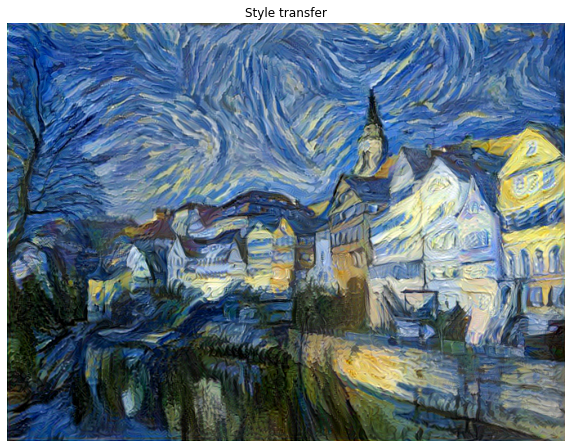

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(postprocess_image(input_image.cpu().detach(), bgr=use_bgr))
plt.title("Style transfer")
plt.axis("off")
plt.show()

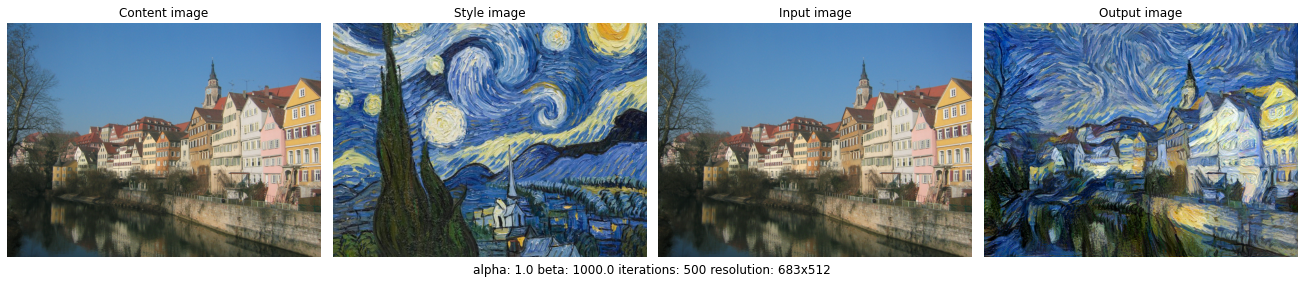

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

ax1.imshow(postprocess_image(content_image.cpu().detach(), bgr=use_bgr))
ax1.set_title("Content image")
ax1.axis("off")
ax2.imshow(postprocess_image(style_image.cpu().detach(), bgr=use_bgr))
ax2.set_title("Style image")
ax2.axis("off")
ax3.imshow(postprocess_image(input_image_start, bgr=use_bgr, noise_image=use_noise_image))
ax3.set_title("Input image")
ax3.axis("off")
ax4.imshow(postprocess_image(input_image.cpu().detach(), bgr=use_bgr))
ax4.set_title("Output image")
ax4.axis("off")
fig.suptitle("alpha: {} beta: {} iterations: {} resolution: {}x{}".format(alpha, beta, max_iter, dims[1], dims[0]), y=0.07)
plt.show()

Сада ће бити поновљен претходни пренос стила, али користећи `torchvision` предтренирани модел:

In [11]:
input_image = torch.autograd.Variable(content_image.clone(), requires_grad=True).to(device)
input_image_start = input_image.clone().cpu().detach()

neural_net = NN(use_authors_model=False) 
neural_net.to(device)

content_outs = neural_net.get_content_features(content_image).detach()
style_outs = [gram_matrix(style_out).detach() for style_out in neural_net.get_style_features(style_image)]

In [12]:
optimizer = torch.optim.LBFGS([input_image])

num_iter = 1

while num_iter <= max_iter:
  optimizer.step(closure)

Iteration:   50 Loss: 20943.42578125
Iteration:  100 Loss: 11190.2998046875
Iteration:  150 Loss: 9325.556640625
Iteration:  200 Loss: 8510.7421875
Iteration:  250 Loss: 8027.6962890625
Iteration:  300 Loss: 7709.5927734375
Iteration:  350 Loss: 7466.810546875
Iteration:  400 Loss: 7288.9443359375
Iteration:  450 Loss: 7146.88134765625
Iteration:  500 Loss: 7036.96826171875


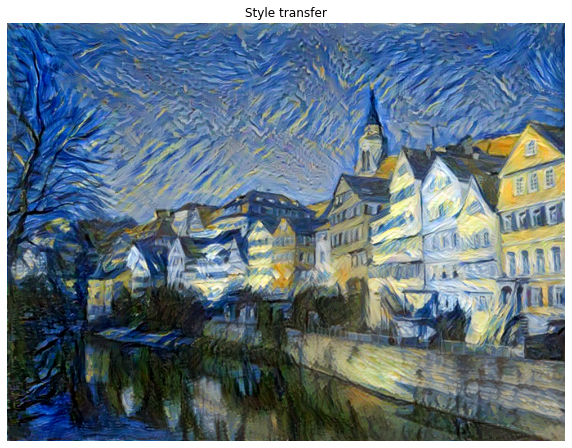

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(postprocess_image(input_image.cpu().detach(), bgr=use_bgr))
plt.title("Style transfer")
plt.axis("off")
plt.show()

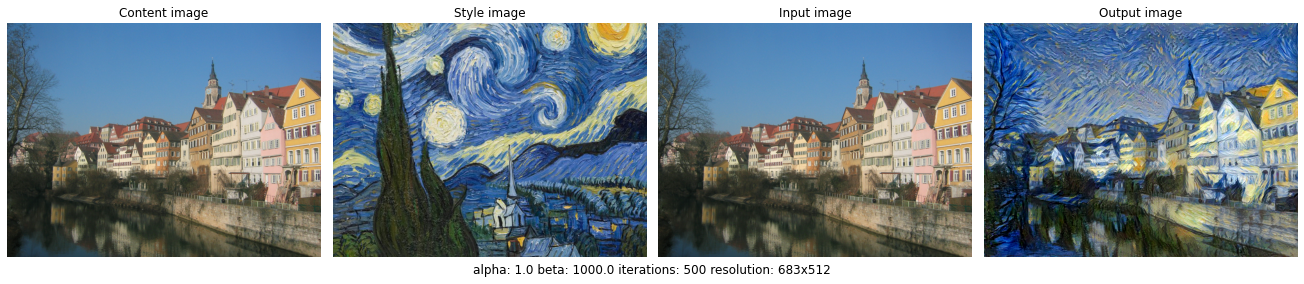

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

ax1.imshow(postprocess_image(content_image.cpu().detach(), bgr=use_bgr))
ax1.set_title("Content image")
ax1.axis("off")
ax2.imshow(postprocess_image(style_image.cpu().detach(), bgr=use_bgr))
ax2.set_title("Style image")
ax2.axis("off")
ax3.imshow(postprocess_image(input_image_start, bgr=use_bgr, noise_image=use_noise_image))
ax3.set_title("Input image")
ax3.axis("off")
ax4.imshow(postprocess_image(input_image.cpu().detach(), bgr=use_bgr))
ax4.set_title("Output image")
ax4.axis("off")
fig.suptitle("alpha: {} beta: {} iterations: {} resolution: {}x{}".format(alpha, beta, max_iter, dims[1], dims[0]), y=0.07)
plt.show()

Чини се да предтренирани модел од аутора даје нешто боље резултате. Следи демонстрација тренирања од слике шума:

In [15]:
use_noise_image = True

input_image = torch.autograd.Variable(torch.randn(content_image.size()).type_as(content_image.data).mul_(255), requires_grad=True)
input_image_start = input_image.clone().cpu().detach()

neural_net = NN(use_authors_model=True) 
neural_net.to(device)

content_outs = neural_net.get_content_features(content_image).detach()
style_outs = [gram_matrix(style_out).detach() for style_out in neural_net.get_style_features(style_image)]

In [16]:
optimizer = torch.optim.LBFGS([input_image])

max_iter = 5000
num_iter = 1
print_every = 250

while num_iter <= max_iter:
  optimizer.step(closure)

Iteration:  250 Loss: 1719437.75
Iteration:  500 Loss: 1252734.375
Iteration:  750 Loss: 1111202.0
Iteration: 1000 Loss: 1046265.5625
Iteration: 1250 Loss: 1008333.5
Iteration: 1500 Loss: 983479.125
Iteration: 1750 Loss: 966259.9375
Iteration: 2000 Loss: 954061.375
Iteration: 2250 Loss: 945834.3125
Iteration: 2500 Loss: 939610.1875
Iteration: 2750 Loss: 934959.5
Iteration: 3000 Loss: 931273.375
Iteration: 3250 Loss: 928417.125
Iteration: 3500 Loss: 926115.0
Iteration: 3750 Loss: 924279.4375
Iteration: 4000 Loss: 922746.0
Iteration: 4250 Loss: 921474.0
Iteration: 4500 Loss: 920470.75
Iteration: 4750 Loss: 919608.0625
Iteration: 5000 Loss: 918832.625


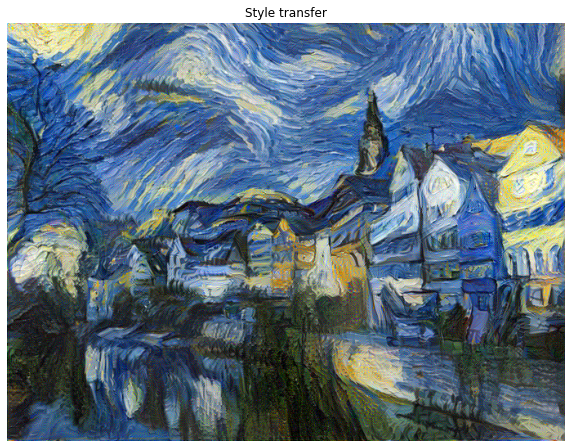

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(postprocess_image(input_image.cpu().detach(), bgr=use_bgr))
plt.title("Style transfer")
plt.axis("off")
plt.show()

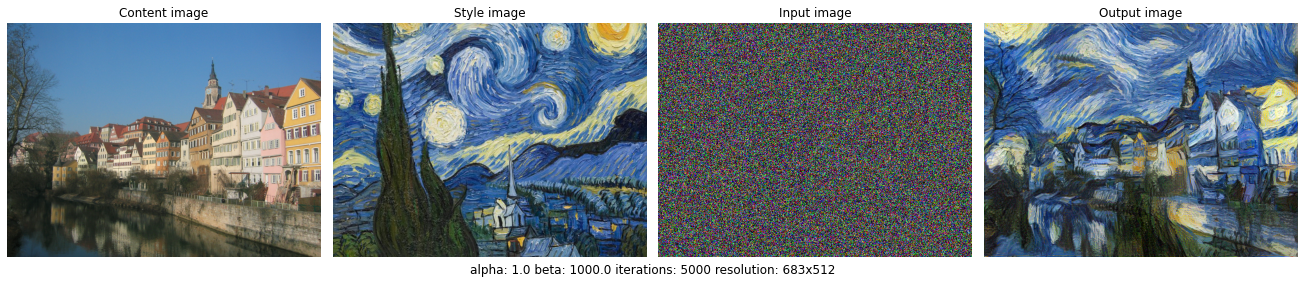

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

ax1.imshow(postprocess_image(content_image.cpu().detach(), bgr=use_bgr))
ax1.set_title("Content image")
ax1.axis("off")
ax2.imshow(postprocess_image(style_image.cpu().detach(), bgr=use_bgr))
ax2.set_title("Style image")
ax2.axis("off")
ax3.imshow(postprocess_image(input_image_start, bgr=use_bgr, noise_image=use_noise_image))
ax3.set_title("Input image")
ax3.axis("off")
ax4.imshow(postprocess_image(input_image.cpu().detach(), bgr=use_bgr))
ax4.set_title("Output image")
ax4.axis("off")
fig.suptitle("alpha: {} beta: {} iterations: {} resolution: {}x{}".format(alpha, beta, max_iter, dims[1], dims[0]), y=0.07)
plt.show()

### Литература

1. Gatys, L. A., Ecker A. S. & Bethge M. (2015). A Neural Algorithm of Artistic Style. arXiv. 10.1167/16.12.326.
2. Gatys, L. A., Ecker A. S. & Bethge M. (2016). Image Style Transfer Using Convolutional Neural Networks. 2414-2423. 10.1109/CVPR.2016.265.
3. Authors' implementation of *Image Style Transfer Using Convolutional Neural Networks* paper. online at: https://github.com/leongatys/PytorchNeuralStyleTransfer